# 02. Neural Network classification with PyTorch

Classification predicts what something is from a list.

In [1]:
## 1. Classification data
from sklearn.datasets import make_circles

# samples
n_samples = 1000
# create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
print(f"first 5 samples of X:\n {X[:5]}")
print(f"first 5 samples of y:\n {y[:5]}")

first 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 samples of y:
 [1 1 1 1 0]


In [4]:
# Make dataframe
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                       "X2": X[:, 1],
                       "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


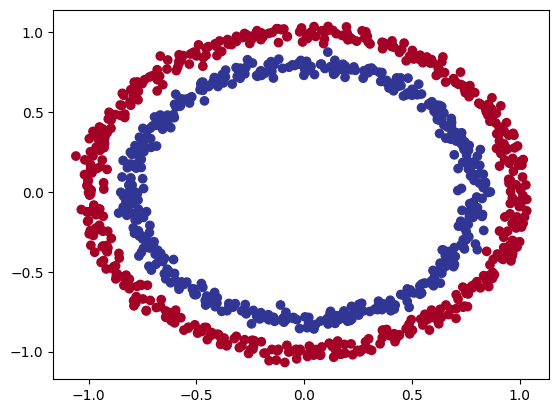

In [5]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

# Checking import and output shapes


In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# frist example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and y {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and y {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and y 1
Shapes for one sample of X: (2,) and y ()


### Convernt data into tensors

In [8]:
import torch
torch.__version__

'2.0.1+cu117'

In [9]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [10]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
type(X), X.type, y.type

(torch.Tensor, <function Tensor.type>, <function Tensor.type>)

In [12]:
# Split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [13]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# Building model

1. Setup device agnositic code
2. Construct model from nn.Module
3. Define loss func and optimizers
4. Create training and test loops

In [14]:
# 1. setup device agnostic code
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 2. Construct model

In [15]:
# 1. construct a model
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. 2 nn.linear layers
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes 2 features in, scales to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes 5 features, classification to 1 (shape of y)


    # 3. define a forward()
    def forward(self, x):
      return self.layer_2(self.layer_1(x))    # x -> layer 1 -> layer 2 -> output (classification)
    
# 4.instantiate an instance of model class and send it to the target device
model_0 = CircleModelV1().to(device)
model_0

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
next(model_0.parameters()).to(device)

Parameter containing:
tensor([[-3.1711e-01, -6.1019e-01],
        [ 3.3589e-01, -6.6356e-01],
        [ 1.8636e-01, -2.0327e-01],
        [ 3.7319e-01, -2.1690e-04],
        [-4.3263e-01, -4.0766e-01]], device='cuda:0', requires_grad=True)

In [17]:
# nn.Sequential() can be used for similar models
# model_0 = nn.Sequential(
#     nn.Linear(in_features=2, out_features=5),
#     nn.Linear(in_features=5, out_features=1)
# ).to(device)
# model_0

In [18]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-3.1711e-01, -6.1019e-01],
                      [ 3.3589e-01, -6.6356e-01],
                      [ 1.8636e-01, -2.0327e-01],
                      [ 3.7319e-01, -2.1690e-04],
                      [-4.3263e-01, -4.0766e-01]], device='cuda:0')),
             ('layer_1.bias',
              tensor([ 0.5810,  0.1011, -0.3431,  0.3415,  0.5604], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.1322,  0.3818, -0.0168, -0.2982, -0.0973]], device='cuda:0')),
             ('layer_2.bias', tensor([0.3500], device='cuda:0'))])

In [19]:
# Predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Len of prediction: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Len of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\n First 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\n First 10 labelss:\n{y_test[:10]}")

Len of prediction: 200, Shape: torch.Size([200, 1])
Len of test samples: 200, Shape: torch.Size([200, 2])

 First 10 predictions:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

 First 10 labelss:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


# loss function and optimizer
loss function
* regression MAE or MSE (mean absolute err or mean squared err)  
* classicification binary cross entropy or categorical cross entropy  

optimizers
* SGD
* Adam


In [20]:
# loss
loss_fn = torch.nn.BCEWithLogitsLoss() # sigmoid activation function included
# optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)


In [21]:
# accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

# Train model

1. forward pass
2. calc loss
3. optimize zero grad
4. loss backward
5. optimizer step

In [22]:
# 
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.0361],
        [0.0384],
        [0.1332],
        [0.0082],
        [0.2968]], device='cuda:0')

In [23]:
# sigmoid activiation function on model logits turns them into prediction probabilities
# range-style round is preformed on prediction probabliy values 
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5090],
        [0.5096],
        [0.5332],
        [0.5020],
        [0.5737]], device='cuda:0')

In [24]:
# find predicted labels
y_preds = torch.round(y_pred_probs)

# logits -> pred probs -> pred labels
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# check equal
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# get rid of the extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

# building a train and test loop

In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits,
                   y_train)
    
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_preds)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)
        
        
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")
        
        

Epoch: 0 | Loss: 0.69642, Acc: 58.25 | Test loss: 0.69439, Test acc: 59.00
Epoch: 10 | Loss: 0.69467, Acc: 51.62 | Test loss: 0.69381, Test acc: 55.50
Epoch: 20 | Loss: 0.69402, Acc: 50.50 | Test loss: 0.69382, Test acc: 53.50
Epoch: 30 | Loss: 0.69373, Acc: 50.12 | Test loss: 0.69394, Test acc: 52.00
Epoch: 40 | Loss: 0.69356, Acc: 50.12 | Test loss: 0.69405, Test acc: 51.00
Epoch: 50 | Loss: 0.69345, Acc: 49.88 | Test loss: 0.69415, Test acc: 52.50
Epoch: 60 | Loss: 0.69336, Acc: 49.75 | Test loss: 0.69422, Test acc: 51.00
Epoch: 70 | Loss: 0.69330, Acc: 49.88 | Test loss: 0.69428, Test acc: 49.50
Epoch: 80 | Loss: 0.69324, Acc: 50.38 | Test loss: 0.69433, Test acc: 49.00
Epoch: 90 | Loss: 0.69320, Acc: 50.50 | Test loss: 0.69437, Test acc: 49.50


## make predictions and eval the model

based on metric the model is not learning

In [32]:
from helper_functions import plot_predictions, plot_decision_boundary


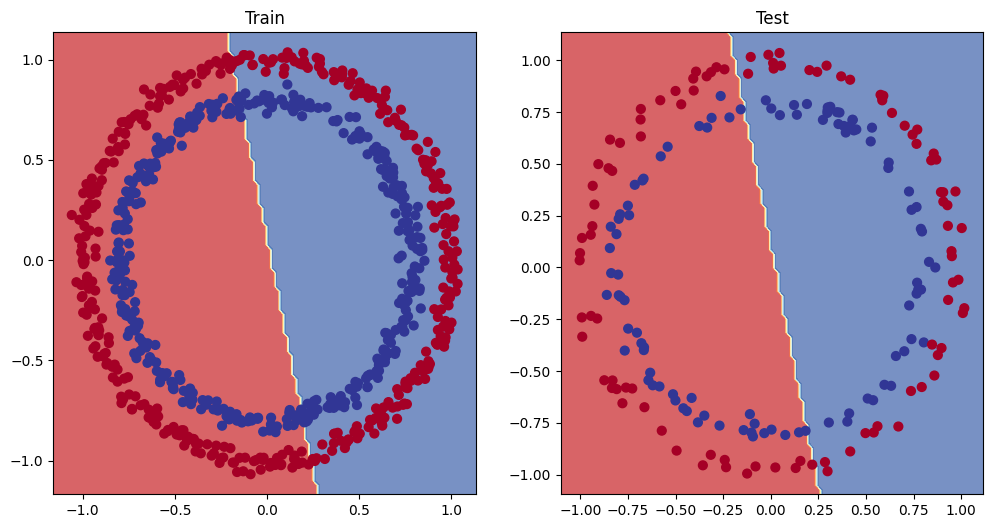

In [33]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)